In [148]:
#Importo las librerias que me interesan
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests

BASE_URI = 'https://api.mercadolibre.com'



In [3]:
def get_site_categories(site):
    '''Funcion para traer la info de las categorias que hay en un site'''
    urls = f'{BASE_URI}/sites/{site}/categories#json'
    response = requests.get(urls)

    if response.status_code == 200:
        return response.json()
    else:
        raise Exception('Error making get api call categories from {}.'.format(site))

def get_subcategories(category):
    '''Funcion para traer la info de las subcategoriascategorias que hay en un site'''
    urls = f'{BASE_URI}/categories/{category}'
    response = requests.get(urls)

    if response.status_code == 200:
        return response.json()['children_categories']
    else:
        raise Exception('Error making get api call subcategories from {}.'.format(category))

def get_items(site,subcategory):
    '''Funcion para traer los items que hay en un site'''
    urls = f'{BASE_URI}/sites/{site}/search?category={subcategory}'
    response = requests.get(urls)

    if response.status_code == 200:
        return response.json()
    else:
        raise Exception('Error making get api call items from {}.'.format(site))
        
def get_item_info(itemid):
    '''Funcion para traer la info de los items'''
    urls = f'{BASE_URI}/items/{itemid}'
    response = requests.get(urls)

    if response.status_code == 200:
        return response.json()
    else:
        raise Exception('Error making get api call item info for item_id {}.'.format(itemid))

def get_categorie_from_name(catjson, elementname):
    '''Funcion para buscar el nombre de una categoria'''
    for subcat in catjson:
        if subcat['name']!= elementname:
            continue
        else:
            return print(subcat['id'])
    raise Exception('Id not found')

In [4]:
data = pd.DataFrame()

selectedcolumns = ['id',
                   'site_id',
                   'price',
                   'sale_price',
                   'currency_id',
                   'available_quantity',
                   'sold_quantity',
                   'buying_mode',
                   'listing_type_id',
                   'condition',
                   'accepts_mercadopago',
                   'original_price',
                   'category_id',
                   'domain_id',
                   'seller.eshop.eshop_status_id',
                   'seller.seller_reputation.power_seller_status',
                   'seller.seller_reputation.level_id',
                   'seller.seller_reputation.metrics.cancellations.rate',
                   'seller.seller_reputation.metrics.claims.rate',
                   'seller.seller_reputation.metrics.delayed_handling_time.rate',
                   'seller.seller_reputation.transactions.canceled',
                   'seller.seller_reputation.transactions.period',
                   'seller.seller_reputation.transactions.ratings.negative',
                   'seller.seller_reputation.transactions.ratings.neutral',
                   'seller.seller_reputation.transactions.ratings.positive',
                   'seller.seller_reputation.transactions.completed',
                   'installments.quantity', #Hacer bool
                   'installments.rate', #Hace bool
                   'address.state_id',
                   'shipping.free_shipping',
                   'shipping.mode',
                   'shipping.store_pick_up',
                   'categ_id_l1',
                   'categ_name_l1',
                   'categ_id_l2',
                   'categ_name_l2'
                  ]

In [15]:
#Creo un dataframe para despues agregar los datos
data = pd.DataFrame()

#defino los sites que voy a analizar

sites=['MLA']

#Busco las categorias del site, subcategorias y los items que se encuentran publicados y los agrego al DF
for site in sites:
    categories = get_site_categories(site)

    for categ in categories:
        subcategories = get_subcategories(categ['id'])

        for subcat in subcategories:
            subcatitems = get_items(site,subcat['id']) 

            dftemp = pd.json_normalize(
                subcatitems,
                record_path = ['results'],
                errors = 'ignore')
            dftemp['categ_id_l1']=str(categ['id'])
            dftemp['categ_name_l1']=str(categ['name'])
            dftemp['categ_id_l2']=str(subcat['id'])
            dftemp['categ_name_l2']=str(subcat['name'])
            data = data.append(dftemp)
            data = data[selectedcolumns]





In [200]:
features_num = ['price', #num
           'available_quantity', #num
           'sold_quantity', #num
           'original_price', #num
           'seller.eshop.eshop_status_id', #num
           'seller.seller_reputation.metrics.cancellations.rate', #num
           'seller.seller_reputation.metrics.claims.rate', #num
           'seller.seller_reputation.metrics.delayed_handling_time.rate', #num
           'seller.seller_reputation.transactions.ratings.negative', #num
           'seller.seller_reputation.transactions.ratings.neutral', #num
           'seller.seller_reputation.transactions.ratings.positive', #num
           'seller.seller_reputation.transactions.completed' #num
          ]
features_str = ['listing_type_id', #str
           'category_id', #str
           'domain_id', #str
           'seller.seller_reputation.power_seller_status', #str
           'seller.seller_reputation.level_id', #str
           'address.state_id', #str
           'shipping.mode', #str
           'categ_id_l1', #str
           'categ_id_l2', #str
          ]
features_bool = ['shipping.free_shipping', #bool
           'shipping.store_pick_up', #bool
          ]

#Acomodo la info que me interesa
data_mod = data
data_mod.head()
data_mod.dropna()
data_mod['offer'] = np.where(data_mod['original_price']>0,True,False)
data_mod['price'] = pd.to_numeric(data_mod['price'])
data_mod['original_price'] = pd.to_numeric(data_mod['original_price'])

for col in features_num:
    data_mod[col] = pd.to_numeric(data_mod[col])

In [75]:
# Saco la data de los articulos que tiene descuento y agrego las columnas con la info relacionada a la baja de precio
data_offer = data_mod[data_mod['offer']==True]
data_offer['discount'] = data_offer['original_price']-data_offer['price']
data_offer['discount_perc'] =1-data_offer['price']/data_offer['original_price']

data_offer['discount'] = pd.to_numeric(data_offer['discount'])
data_offer['discount_perc'] = pd.to_numeric(data_offer['discount_perc'])
data_offer['price'] = pd.to_numeric(data_offer['price'])
data_offer['original_price'] = pd.to_numeric(data_offer['original_price'])


/root/.cache/pypoetry/virtualenvs/app-noFtLz8P-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/root/.cache/pypoetry/virtualenvs/app-noFtLz8P-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/root/.cache/pypoetry/virtualenvs/app-noFtLz8P-py3.7/lib/python3.7/site-packages/ipykernel

In [98]:
categ_data = data_mod.groupby('categ_name_l1').agg(
    qty = pd.NamedAgg(column='id', aggfunc="count"),
    pub_price_max = pd.NamedAgg(column='price', aggfunc=max),
    pub_price_min = pd.NamedAgg(column='price', aggfunc=min),
    pub_price_med = pd.NamedAgg(column='original_price', aggfunc=np.mean),
    sold_qty = pd.NamedAgg(column='sold_quantity', aggfunc=sum)).reset_index()

categ_offer = data_offer.groupby('categ_name_l1').agg(
    offer_qty = pd.NamedAgg(column='offer', aggfunc=sum),
    offer_price_max = pd.NamedAgg(column='price', aggfunc=max),
    offer_price_min = pd.NamedAgg(column='price', aggfunc=min),
    offer_price_med = pd.NamedAgg(column='original_price', aggfunc=np.mean),
    original_price_max = pd.NamedAgg(column='original_price', aggfunc=max),
    original_price_min = pd.NamedAgg(column='original_price', aggfunc=min),
    original_price_med = pd.NamedAgg(column='original_price', aggfunc=np.mean),
    discount_max = pd.NamedAgg(column='discount', aggfunc=max),
    discount_min = pd.NamedAgg(column='discount', aggfunc=min),
    discount_avg = pd.NamedAgg(column='discount', aggfunc=np.mean),
    discount_perc_max = pd.NamedAgg(column='discount_perc', aggfunc=max),
    sold_qty = pd.NamedAgg(column='sold_quantity', aggfunc=sum)).reset_index()
categ_offer = categ_offer.set_index('categ_name_l1')
categ_data = categ_data.set_index('categ_name_l1')
categ_offer['offer_qty'] = pd.to_numeric(categ_offer['offer_qty'])
categ_data['qty'] = pd.to_numeric(categ_data['qty'])
#Aca veo el top 10 de ofertas
categ_offer.sort_values(by='offer_qty', ascending=False).head(10)

,offer_qty,offer_price_max,offer_price_min,offer_price_med,original_price_max,original_price_min,original_price_med,discount_max,discount_min,discount_avg,discount_perc_max,sold_qty
categ_name_l1,,,,,,,,,,,,
Deportes y Fitness,306,167216.00,198.00,8015.000359,177889.0,220.00,8015.000359,43001.00,0.0,1447.234935,0.625050,681013.0
Juegos y Juguetes,203,65999.34,359.10,8418.575813,99999.0,399.00,8418.575813,33999.66,0.0,2022.672069,0.611167,103691.0
Accesorios para Vehículos,134,66266.00,427.50,13505.493433,66266.0,427.50,13505.493433,20001.00,0.0,2364.275896,0.700250,169902.0
Ropa y Accesorios,121,22990.00,546.00,4715.956777,29985.0,650.00,4715.956777,11001.00,0.0,961.783967,0.647118,360204.0
"Electrónica, Audio y Video",99,224599.00,271.70,19422.333434,238449.0,286.00,19422.333434,80001.00,0.0,6911.196566,0.651000,205677.0
"Hogar, Muebles y Jardín",94,30399.05,80.99,6207.268404,31999.0,89.99,6207.268404,6550.00,0.0,1234.401277,0.760200,585663.0
Belleza y Cuidado Personal,90,19999.00,174.00,6534.271444,38000.0,220.00,6534.271444,21001.00,0.0,2183.676333,0.732273,197284.0
Computación,84,163998.36,329.00,34689.424286,199998.0,349.00,34689.424286,80001.00,0.0,7263.892738,0.650500,157047.0
Cámaras y Accesorios,81,224599.00,382.20,26555.287037,238449.0,459.00,26555.287037,53050.00,0.0,5395.660864,0.685857,54822.0


In [99]:
categ_data.sort_values(by='qty', ascending=False).head(10)

,qty,pub_price_max,pub_price_min,pub_price_med,sold_qty
categ_name_l1,,,,,
Deportes y Fitness,1950,1.849999e+06,100.0,8015.000359,1774869.0
Juegos y Juguetes,1250,2.500000e+05,100.0,8418.575813,478683.0
Ropa y Accesorios,1100,4.555500e+04,210.0,4715.956777,1675244.0
Accesorios para Vehículos,1050,6.534900e+05,219.0,13505.493433,802031.0
Computación,949,3.292262e+05,100.0,34689.424286,384215.0
Servicios,900,1.111111e+08,50.0,NaN,46573.0
Inmuebles,800,3.108568e+07,65.0,990000.000000,0.0
"Electrónica, Audio y Video",750,2.245990e+05,99.0,19422.333434,684493.0
Bebés,750,3.690000e+04,200.0,7450.911111,501051.0


Es evidente que hay outliers, habria que hacer una limpieza antes de hacer el entrenamiento.
Veo si a parte de los descuentos ofrecen algo mas y si los vendedores son de categorias altas 
    o si quieren ganar reputacion con estas ofertas

In [ ]:
categ_data = data_mod.groupby('categ_name_l1').agg(
    qty = pd.NamedAgg(column='id', aggfunc="count"),
    pub_price_max = pd.NamedAgg(column='price', aggfunc=max),
    pub_price_min = pd.NamedAgg(column='price', aggfunc=min),
    pub_price_med = pd.NamedAgg(column='original_price', aggfunc=np.mean),
    sold_qty = pd.NamedAgg(column='sold_quantity', aggfunc=sum)).reset_index()

In [175]:
seller_columns =['seller.eshop.eshop_status_id',
                   'seller.seller_reputation.power_seller_status',
                   'seller.seller_reputation.level_id', #no usar
                   'seller.seller_reputation.metrics.cancellations.rate',
                   'seller.seller_reputation.metrics.claims.rate',
                   'seller.seller_reputation.metrics.delayed_handling_time.rate',
                   'seller.seller_reputation.transactions.canceled',
                   'seller.seller_reputation.transactions.period',
                   'seller.seller_reputation.transactions.ratings.negative',
                   'seller.seller_reputation.transactions.ratings.neutral',
                   'seller.seller_reputation.transactions.ratings.positive',
                   'seller.seller_reputation.transactions.completed'] 
data_seller_offer = data_offer[seller_columns]
data_seller_offer.head()

,seller.eshop.eshop_status_id,seller.seller_reputation.power_seller_status,seller.seller_reputation.level_id,seller.seller_reputation.metrics.cancellations.rate,seller.seller_reputation.metrics.claims.rate,seller.seller_reputation.metrics.delayed_handling_time.rate,seller.seller_reputation.transactions.canceled,seller.seller_reputation.transactions.period,seller.seller_reputation.transactions.ratings.negative,seller.seller_reputation.transactions.ratings.neutral,seller.seller_reputation.transactions.ratings.positive,seller.seller_reputation.transactions.completed
6,1.0,platinum,5_green,0.0059,0.0162,0.0620,16528.0,historic,0.05,0.03,0.92,211261.0
10,NaN,platinum,5_green,0.0046,0.0056,0.0053,2313.0,historic,0.02,0.01,0.97,29213.0
14,1.0,platinum,5_green,0.0005,0.0100,0.0003,53046.0,historic,0.05,0.02,0.93,857850.0
16,1.0,platinum,5_green,0.0000,0.0058,0.0107,203.0,historic,0.04,0.03,0.93,5665.0
19,1.0,platinum,5_green,0.0015,0.0118,0.0050,3287.0,historic,0.02,0.02,0.96,49654.0


In [ ]:
#Tuve problemas con un loop para crear dataframes con diferentes nombres. Sigo a mano
a = 11
rep_level = data_seller_offer.groupby(seller_columns[a]).agg(
    qty = pd.NamedAgg(column=seller_columns[a], aggfunc="count")).reset_index()
rep_level = rep_level.set_index(seller_columns[a])
rep_level['qty'] = pd.to_numeric(rep_level['qty'])
rep_level.sort_values(by='qty', ascending=False).head(100)

<AxesSubplot:xlabel='seller.eshop.eshop_status_id'>

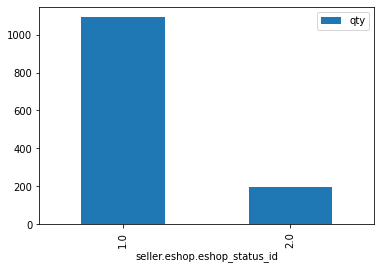

In [174]:
rep_shop = data_seller_offer.groupby(seller_columns[0]).agg(
    qty = pd.NamedAgg(column=seller_columns[0], aggfunc="count")).reset_index()
rep_shop = rep_shop.set_index(seller_columns[0])
rep_shop['qty'] = pd.to_numeric(rep_shop['qty'])
rep_shop.sort_values(by='qty', ascending=False).head()

rep_shop.plot(kind="bar")

In [ ]:
Aquellos sellers que tienen Eshop con status 1 tienen mas ofertas.

<AxesSubplot:xlabel='seller.seller_reputation.power_seller_status'>

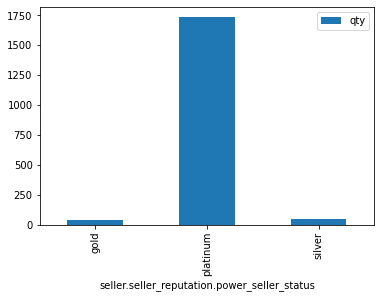

In [166]:
rep_power_seller = data_seller_offer.groupby(seller_columns[1]).agg(
    qty = pd.NamedAgg(column=seller_columns[1], aggfunc="count")).reset_index()
rep_power_seller = rep_power_seller.set_index(seller_columns[1])
rep_power_seller['qty'] = pd.to_numeric(rep_power_seller['qty'])
rep_power_seller.sort_values(by='qty', ascending=False).head()

rep_power_seller.plot(kind="bar")

Aquellos que tienen mayor status en la plataforma tienen mas ofertas.

In [170]:
rep_level = data_seller_offer.groupby(seller_columns[2]).agg(
    qty = pd.NamedAgg(column=seller_columns[2], aggfunc="count")).reset_index()
rep_level = rep_level.set_index(seller_columns[2])
rep_level['qty'] = pd.to_numeric(rep_level['qty'])
rep_level.sort_values(by='qty', ascending=False).head()



,qty
seller.seller_reputation.level_id,
5_green,1829
4_light_green,1


La gran mayoria de los seller que venden con ofertas tienen level 5.

<AxesSubplot:xlabel='seller.seller_reputation.transactions.ratings.positive'>

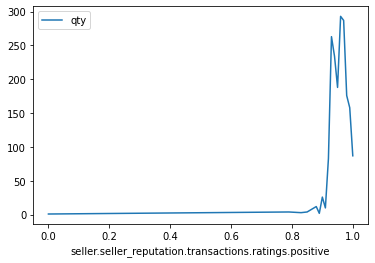

In [164]:
rep_positive = data_seller_offer.groupby(seller_columns[10]).agg(
    qty = pd.NamedAgg(column=seller_columns[10], aggfunc="count")).reset_index()
rep_positive = rep_positive.set_index(seller_columns[10])
rep_positive['qty'] = pd.to_numeric(rep_positive['qty'])
rep_positive.sort_values(by='qty', ascending=False).head(100)
#rep_positive[seller_columns[10]].fill_na(0)
rep_positive.fillna(0)

rep_positive.plot(y='qty')


Vemos que la buena reputacion tambien correlacion con la cantidad de ofertas.

<AxesSubplot:xlabel='seller.seller_reputation.transactions.ratings.neutral'>

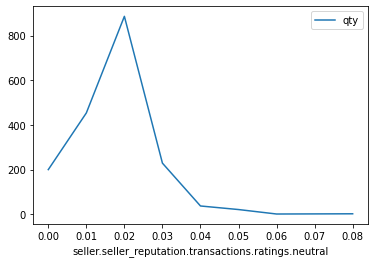

In [165]:
rep_neutral = data_seller_offer.groupby(seller_columns[9]).agg(
    qty = pd.NamedAgg(column=seller_columns[9], aggfunc="count")).reset_index()
rep_neutral = rep_neutral.set_index(seller_columns[9])
rep_neutral['qty'] = pd.to_numeric(rep_neutral['qty'])
rep_neutral.sort_values(by='qty', ascending=False).head(100)
#rep_positive[seller_columns[9]].fill_na(0)
rep_neutral.fillna(0)

rep_neutral.plot(y='qty')

En el caso de la reputacion neutral no es inversamente proporcional. 
Aunque aquellos que llevan una rep menor a 0.3 tienen mayor cantidad de ventas

In [177]:
shipping_columns = ['shipping.free_shipping',
                   'shipping.mode',
                   'shipping.store_pick_up']

data_shipping_offer = data_offer[shipping_columns]
data_shipping_offer.head()

,shipping.free_shipping,shipping.mode,shipping.store_pick_up
6,True,me2,False
10,False,me2,False
14,False,me2,False
16,True,me2,False
19,True,me2,False


<AxesSubplot:xlabel='shipping.free_shipping'>

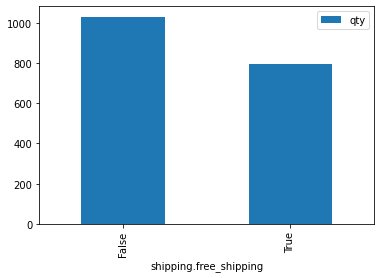

In [180]:
free_shipping = data_shipping_offer.groupby(shipping_columns[0]).agg(
    qty = pd.NamedAgg(column=shipping_columns[0], aggfunc="count")).reset_index()
free_shipping = free_shipping.set_index(shipping_columns[0])
free_shipping['qty'] = pd.to_numeric(free_shipping['qty'])
free_shipping.sort_values(by='qty', ascending=False).head(100)
#rep_positive[seller_columns[9]].fill_na(0)
free_shipping.fillna(0)

free_shipping.plot(kind="bar")

El 40% de las ofertas tambien ofrecen envio gratuito

<AxesSubplot:xlabel='shipping.mode'>

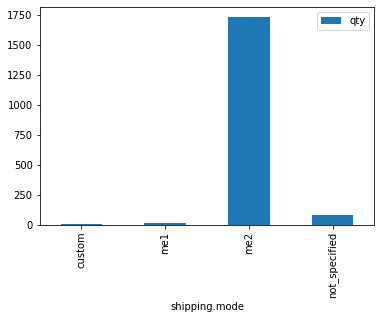

In [183]:
mode_shipping = data_shipping_offer.groupby(shipping_columns[1]).agg(
    qty = pd.NamedAgg(column=shipping_columns[1], aggfunc="count")).reset_index()
mode_shipping = mode_shipping.set_index(shipping_columns[1])
mode_shipping['qty'] = pd.to_numeric(mode_shipping['qty'])
mode_shipping.sort_values(by='qty', ascending=False).head(100)
#rep_positive[seller_columns[9]].fill_na(0)
mode_shipping.fillna(0)

mode_shipping.plot(kind="bar")

La gran mayoria de las ofertas utilizan mercado envios como opcion de envio.

In [185]:
pickup_shipping = data_shipping_offer.groupby(shipping_columns[2]).agg(
    qty = pd.NamedAgg(column=shipping_columns[2], aggfunc="count")).reset_index()
pickup_shipping = pickup_shipping.set_index(shipping_columns[2])
pickup_shipping['qty'] = pd.to_numeric(pickup_shipping['qty'])
pickup_shipping.sort_values(by='qty', ascending=False).head(100)
#rep_positive[seller_columns[9]].fill_na(0)
pickup_shipping.fillna(0)

pickup_shipping.plot(kind="bar")

,qty
shipping.store_pick_up,
False,1766
True,65


Menos del 5% de las publicaciones con oferta ofrecen pasar a buscar el producto por el local/domicilio del vendedor

In [186]:
venta_columns = ['listing_type_id',
                    'condition',
                    'accepts_mercadopago']

data_venta_offer = data_offer[venta_columns]
data_venta_offer.head()

,listing_type_id,condition,accepts_mercadopago
6,gold_pro,new,True
10,gold_special,new,True
14,gold_special,new,True
16,gold_special,new,True
19,gold_special,new,True


<AxesSubplot:xlabel='listing_type_id'>

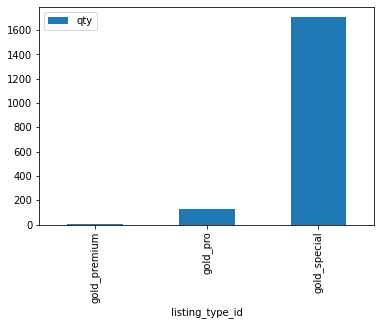

In [188]:
listing_ventas = data_venta_offer.groupby(venta_columns[0]).agg(
    qty = pd.NamedAgg(column=venta_columns[0], aggfunc="count")).reset_index()
listing_ventas = listing_ventas.set_index(venta_columns[0])
listing_ventas['qty'] = pd.to_numeric(listing_ventas['qty'])
listing_ventas.sort_values(by='qty', ascending=False).head(100)
#rep_positive[seller_columns[9]].fill_na(0)
listing_ventas.fillna(0)

listing_ventas.plot(kind="bar")

<AxesSubplot:xlabel='condition'>

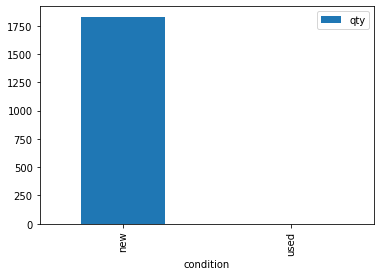

In [190]:
condition_ventas = data_venta_offer.groupby(venta_columns[1]).agg(
    qty = pd.NamedAgg(column=venta_columns[1], aggfunc="count")).reset_index()
condition_ventas = condition_ventas.set_index(venta_columns[1])
condition_ventas['qty'] = pd.to_numeric(condition_ventas['qty'])
condition_ventas.sort_values(by='qty', ascending=False).head(100)
#rep_positive[seller_columns[9]].fill_na(0)
condition_ventas.fillna(0)

condition_ventas.plot(kind="bar")

<AxesSubplot:xlabel='accepts_mercadopago'>

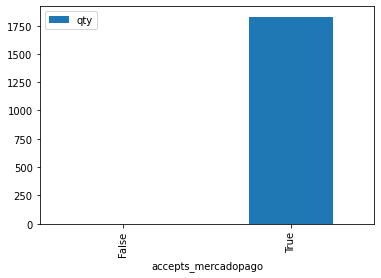

In [191]:
mp_ventas = data_venta_offer.groupby(venta_columns[2]).agg(
    qty = pd.NamedAgg(column=venta_columns[2], aggfunc="count")).reset_index()
mp_ventas = mp_ventas.set_index(venta_columns[2])
mp_ventas['qty'] = pd.to_numeric(mp_ventas['qty'])
mp_ventas.sort_values(by='qty', ascending=False).head(100)
#rep_positive[seller_columns[9]].fill_na(0)
mp_ventas.fillna(0)

mp_ventas.plot(kind="bar")

In [198]:
data_mod['shipping.store_pick_up'].describe()

count     16523
unique        2
top       False
freq      16315
Name: shipping.store_pick_up, dtype: object